# Practical Machine Learning for Physicists
## Coursework C - Part 2

For both of these tasks we want you to implement autoencoder networks that:
- Train on randomly generated circles (using the circle_generator function below)
- Use 27x27 pixel images
- Use no more than 30,000 randomly generated samples (e.g. batchsize 30 and 1000 steps, or batchsize 1000 and 30 steps, or anywhere inbetween) in training the final networks for each task
- Use the mean_squared_error loss function
- Fulfil the network size requirement listed in the task (can be verifired using the print_layers function, after the network is partially trained)

### Task 1:
Implement any network design, but the bottleneck must contain no more than 9 neurons.

### Task 2:
Implement any network design, but the bottleneck must contain no more than 3 neurons.



#### Practicalities
You should use this notebook for your work and upload it to  Moodle. You are expected to use TensorFlow and Keras to complete these tasks. The notebook should be self-contained and able to be executed if necessary. Marks will be awarded for (roughly equally weighted):
- Overall notebook clarity (both in terms of good coding practice and coherent discussion)
- Task 1 performance (0.02 is a good target cost to do better than)
- Task 2 performance ( a good target here is left for the student to determine)


In [10]:
#Import libraries
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras


import matplotlib.style
import matplotlib as mpl

print(tf.__version__)

2.15.0


In [11]:
#A big messy function to do the training
# model -- our keras neural model autoencoder
# image_generator -- a function to generate random images for the training (see below for examples)
# img_size -- the size of our image in pixels
# batchsize -- the number of images to include in each training batch
# steps -- the number of steps taken in the training
#
# returns an array of the costs
def generate_and_train(model,image_generator,img_size,batchsize,steps):

    #Generate an array of the numbers 1 to img_size and create a meshgrid from them
    pixels=np.linspace(-1,1,img_size)
    x,y=np.meshgrid(pixels,pixels)

    #Now create a test image using 1 call to image_generator
    #y_test=np.zeros([1,pixels,pixels,1])
    #y_test[:,:,:,0]=image_generator(1,x,y)

    #Now create the empty arrays for the images and cost
    y_in=np.zeros([batchsize,img_size,img_size,1])
    y_target=np.zeros([batchsize,img_size,img_size,1])
    cost=np.zeros(steps)

    #Loop through the steps, get a random batch of samples, train the model, repeat
    for k in range(steps):
        # produce samples:
        y_in[:,:,:,0]=image_generator(batchsize,x,y)
        y_target=np.copy(y_in) # autoencoder wants to reproduce its input!

        # do one training step on this batch of samples:
        cost[k]=model.train_on_batch(y_in,y_target)

    return cost,y_target

def get_test_image(image_generator,img_size):
    #Generate an array of the numbers 1 to img_size and create a meshgrid from them
    pixels=np.linspace(-1,1,img_size)
    x,y=np.meshgrid(pixels,pixels)

    #Now create a test image using 1 call to image_generator
    y_test=np.zeros([1,img_size,img_size,1])
    y_test[:,:,:,0]=image_generator(1,x,y)
    return y_test

# A function to generate and plot a single test image and the output of our model
# only to be called after training the model
def plot_test_image(model,image_generator,img_size):
    #Get random test image
    y_test=get_test_image(image_generator,img_size)

    #Create the output image
    y_test_out=model.predict_on_batch(y_test)
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(y_test[0,:,:,0],origin='lower')
    ax[0].set_title("Input")
    ax[1].imshow(y_test_out[0,:,:,0],origin='lower')
    ax[1].set_title("Output")

def print_layers(network, y_in):
    """
    Call this on some test images y_in, to get a print-out of
    the layer sizes. Shapes shown are (batchsize,pixels,pixels,channels).
    After a call to the visualization routine, y_target will contain
    the last set of training images, so you could feed those in here.
    """
    layer_features=get_layer_activations(network,y_in)
    #print(layer_features)
    for idx,feature in enumerate(layer_features):
        s=np.shape(feature)
        print("Layer "+str(idx)+": "+str(s[1]*s[2]*s[3])+" neurons / ", s)

def get_layer_activation_extractor(network):
    #print(network.inputs)
    #for layer in network.layers:
    #    print(layer.output)
    return(keras.Model(inputs=network.inputs,
                            outputs=[layer.output for layer in network.layers]))

def get_layer_activations(network, y_in):
    """
    Call this on some test images y_in, to get the intermediate
    layer neuron values. These are returned in a list, with one
    entry for each layer (the entries are arrays).
    """
    extractor=get_layer_activation_extractor(network)
    #print(extractor)
    layer_features = extractor(y_in)
    return layer_features


## Circle generator


In [12]:
# A simple image generator that returns an array of batchsize images
# each image has a size of x * y pixels
# in this image each image has a randomly placed circle (and the circle is of random size)
def circle_generator(batchsize,x,y):
    R=np.random.uniform(size=batchsize)
    x0=np.random.uniform(size=batchsize,low=-1,high=1)
    y0=np.random.uniform(size=batchsize,low=-1,high=1)
    return( 1.0*((x[None,:,:]-x0[:,None,None])**2 + (y[None,:,:]-y0[:,None,None])**2 < R[:,None,None]**2) )


In [114]:
#Task 1
model=keras.models.Sequential()
#Convolutional Layer 1
model.add(keras.layers.Conv2D(26, 6, input_shape=(None, None, 1), activation="relu", padding='same'))
model.add(keras.layers.AveragePooling2D(pool_size=(3, 3), padding='same'))  # down

# Convolutional Layer 2
model.add(keras.layers.Conv2D(13, 6, activation="relu", padding='same'))
model.add(keras.layers.AveragePooling2D(pool_size=(3, 3), padding='same'))  # down

# Bottleneck Layer
model.add(keras.layers.Conv2D(1, 3, activation="relu", padding='same')) #Bottleneck

# Up-sampling Layer 1
model.add(keras.layers.UpSampling2D(size=(3, 3)))  # up
model.add(keras.layers.Conv2D(13, 6, activation="relu", padding='same'))

# Up-sampling Layer 2
model.add(keras.layers.UpSampling2D(size=(3, 3)))  # up
model.add(keras.layers.Conv2D(26, 6, activation="relu", padding='same'))

# Output Layer
model.add(keras.layers.Conv2D(1, 12, activation="relu", padding='same'))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_258 (Conv2D)         (None, None, None, 26)    962       
                                                                 
 average_pooling2d_94 (Aver  (None, None, None, 26)    0         
 agePooling2D)                                                   
                                                                 
 conv2d_259 (Conv2D)         (None, None, None, 13)    12181     
                                                                 
 average_pooling2d_95 (Aver  (None, None, None, 13)    0         
 agePooling2D)                                                   
                                                                 
 conv2d_260 (Conv2D)         (None, None, None, 1)     118       
                                                                 
 up_sampling2d_86 (UpSampli  (None, None, None, 1)   

Layer 0: 18954 neurons /  (30, 27, 27, 26)
Layer 1: 2106 neurons /  (30, 9, 9, 26)
Layer 2: 1053 neurons /  (30, 9, 9, 13)
Layer 3: 117 neurons /  (30, 3, 3, 13)
Layer 4: 9 neurons /  (30, 3, 3, 1)
Layer 5: 81 neurons /  (30, 9, 9, 1)
Layer 6: 1053 neurons /  (30, 9, 9, 13)
Layer 7: 9477 neurons /  (30, 27, 27, 13)
Layer 8: 18954 neurons /  (30, 27, 27, 26)
Layer 9: 729 neurons /  (30, 27, 27, 1)


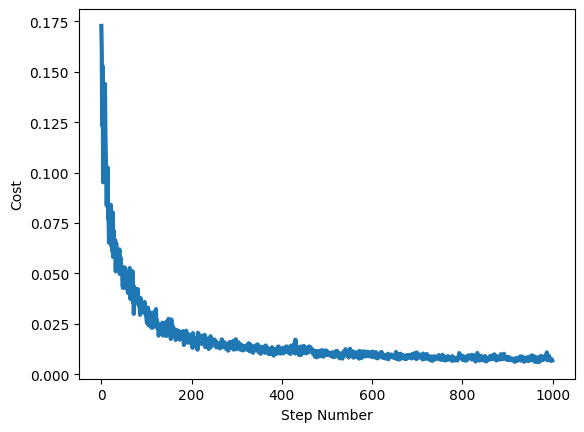

In [115]:
# Model training
steps=1000
cost,y_target=generate_and_train(model,circle_generator,img_size=27,batchsize=30,steps=steps)
#Plot the cost
fig, ax = plt.subplots()
stepArray=np.arange(steps)
ax.plot(stepArray,cost,linewidth=3)
ax.set_xlabel("Step Number")
ax.set_ylabel("Cost")

print_layers(model,y_target)

0.006078007631003857


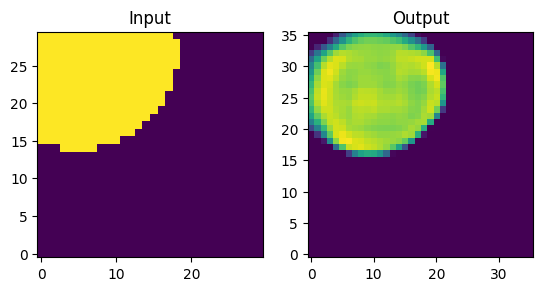

In [116]:
plot_test_image(model,circle_generator,30)
print(min(cost))

In [17]:
#Task 2
model2=keras.models.Sequential()
#Convolutional Layer 1
model2.add(keras.layers.Conv2D(26, 6, input_shape=(None, None, 1), activation="relu", padding='same'))
model2.add(keras.layers.AveragePooling2D(pool_size=(3, 3), padding='same'))  # down

# Convolutional Layer 2
model2.add(keras.layers.Conv2D(13, 6, activation="relu", padding='same'))
model2.add(keras.layers.AveragePooling2D(pool_size=(3, 3), padding='same'))  # down

# Bottleneck Layer
model2.add(keras.layers.Conv2D(1, 3, activation="relu", padding='same')) #Bottleneck
model2.add(keras.layers.AveragePooling2D(pool_size=(1, 3), padding='same'))

# Up-sampling Layer 1
model2.add(keras.layers.UpSampling2D(size=(3, 9)))  # up
model2.add(keras.layers.Conv2D(13, 6, activation="relu", padding='same'))

# Up-sampling Layer 2
model2.add(keras.layers.UpSampling2D(size=(3, 3)))  # up
model2.add(keras.layers.Conv2D(26, 6, activation="relu", padding='same'))

# Output Layer
model2.add(keras.layers.Conv2D(1, 12, activation="relu", padding='same'))

model2.compile(loss='mean_squared_error', optimizer='adam')
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, None, None, 26)    962       
                                                                 
 average_pooling2d_9 (Avera  (None, None, None, 26)    0         
 gePooling2D)                                                    
                                                                 
 conv2d_19 (Conv2D)          (None, None, None, 13)    12181     
                                                                 
 average_pooling2d_10 (Aver  (None, None, None, 13)    0         
 agePooling2D)                                                   
                                                                 
 conv2d_20 (Conv2D)          (None, None, None, 1)     118       
                                                                 
 average_pooling2d_11 (Aver  (None, None, None, 1)    

Layer 0: 18954 neurons /  (30, 27, 27, 26)
Layer 1: 2106 neurons /  (30, 9, 9, 26)
Layer 2: 1053 neurons /  (30, 9, 9, 13)
Layer 3: 117 neurons /  (30, 3, 3, 13)
Layer 4: 9 neurons /  (30, 3, 3, 1)
Layer 5: 3 neurons /  (30, 3, 1, 1)
Layer 6: 81 neurons /  (30, 9, 9, 1)
Layer 7: 1053 neurons /  (30, 9, 9, 13)
Layer 8: 9477 neurons /  (30, 27, 27, 13)
Layer 9: 18954 neurons /  (30, 27, 27, 26)
Layer 10: 729 neurons /  (30, 27, 27, 1)


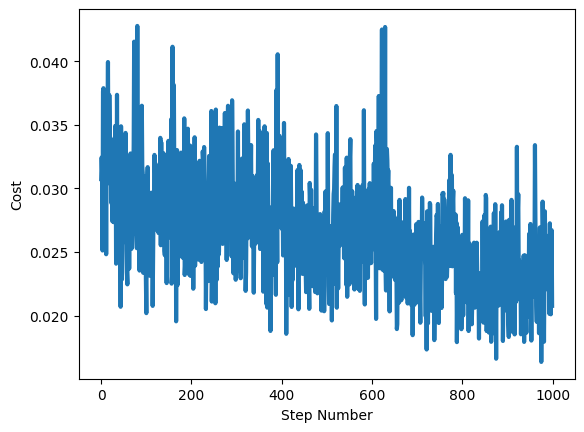

In [21]:
#Model 2 training
steps=1000
cost2,y_target=generate_and_train(model2,circle_generator,img_size=27,batchsize=30,steps=steps)
#Plot the cost
fig, ax = plt.subplots()
stepArray=np.arange(steps)
ax.plot(stepArray,cost2,linewidth=3)
ax.set_xlabel("Step Number")
ax.set_ylabel("Cost")
print_layers(model2,y_target)

0.016349947080016136


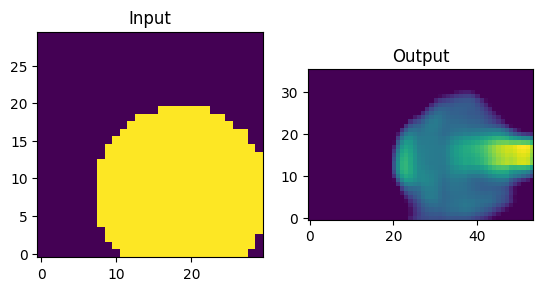

In [22]:
plot_test_image(model2,circle_generator,30)
print(min(cost2))